In [1]:
import os
import json
import numpy as np
import xarray as xr
import geopandas as gpd

import cartopy.crs as ccrs

from multiprocessing import Pool

from playsound import playsound

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import sys
sys.path.append(os.path.abspath(".."))
from function import ART_downscale as ART_down

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


In [2]:
# product, time_reso = 'CMORPH', '3h'
# product, time_reso = 'ERA5', '1dy'
product, time_reso = 'ERA5', '3h'
# product, time_reso = 'IMERG', '1dy'
# product, time_reso = 'IMERG', '3h'
# product, time_reso = 'PERSIANN', '1dy'
# product, time_reso = 'MSWEP', '3h'
# product, time_reso = 'SM2RAIN', '1dy'
# product, time_reso = 'GSMaP', '3h'
# product, time_reso = 'CHIRPS', '1dy'

if product == 'SM2RAIN':
    yy_s, yy_e = 2007, 2012
    # yy_s, yy_e = 2007, 2022
    year_vector = np.arange(yy_s, yy_e+1)
else:
    yy_s, yy_e = 2002, 2012
    # yy_s, yy_e = 2002, 2023
    year_vector = np.arange(yy_s, yy_e+1)

years_num = yy_e - yy_s + 1
lon_min, lon_max, lat_min, lat_max = 10.5, 13.5, 44.5, 47

In [3]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite')

In [4]:
json_read = f'../json/{product}_{time_reso}.json'

if os.path.exists(json_read):
    with open (json_read) as f:
        param = json.load(f)
else:
    raise SystemExit(f"File not found: {json_read}")

NEIBHR = 2*param['npix']+1

print(f'Read json file   : {json_read.split('/')[-1]}')
print(f'Number of threads: {param['BETA_cores']}')
print(f'Neighborhood area: {NEIBHR}x{NEIBHR}')
print()

Read json file   : ERA5_3h.json
Number of threads: 20
Neighborhood area: 5x5



In [5]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    VENETO = gpd.read_file(os.path.join(veneto_dir,'Veneto.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

## Load DATA

In [6]:
print(f'Reading Data File : {param['file']}') 
if product == 'SM2RAIN':
    dir_data = os.path.join(dir_base,product,'ASCAT',time_reso,param['file'])
else:
    dir_data = os.path.join(dir_base,product,time_reso,param['file'])

PRE_data = xr.open_dataset(dir_data)
PRE_data = PRE_data.sel(time=PRE_data.time.dt.year.isin([np.arange(yy_s,yy_e+1)]))

if product == 'MSWEP' or product == 'PERSIANN' or product == 'SM2RAIN' or product == 'ERA5' or product == 'GSMaP':
    PRE_data = PRE_data.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max))
else:
    PRE_data = PRE_data.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

if time_reso == '3h':
    PRE_data = PRE_data.resample(time ='D').sum(dim='time', skipna=False)

time_vector = PRE_data['time'].data

lats = PRE_data['lat'].data
lons = PRE_data['lon'].data
lon2d, lat2d = np.meshgrid(lons, lats)

PRE_data

Reading Data File : ERA5_Italy_3h_2000_01_01_2023_12_31.nc


<xarray.Dataset> Size: 2MB
Dimensions:  (time: 4018, lat: 11, lon: 13)
Coordinates:
  * lat      (lat) float64 88B 47.0 46.75 46.5 46.25 ... 45.25 45.0 44.75 44.5
  * lon      (lon) float64 104B 10.5 10.75 11.0 11.25 ... 12.75 13.0 13.25 13.5
  * time     (time) datetime64[ns] 32kB 2002-01-01 2002-01-02 ... 2012-12-31
Data variables:
    PRE      (time, lat, lon) float32 2MB 0.0577 0.04196 0.04578 ... 0.0 0.0
Attributes:
    description:  ERA5 3 hours data for Italy region

Text(0.0, 1.0, '(c) Daily maximum rainfall')

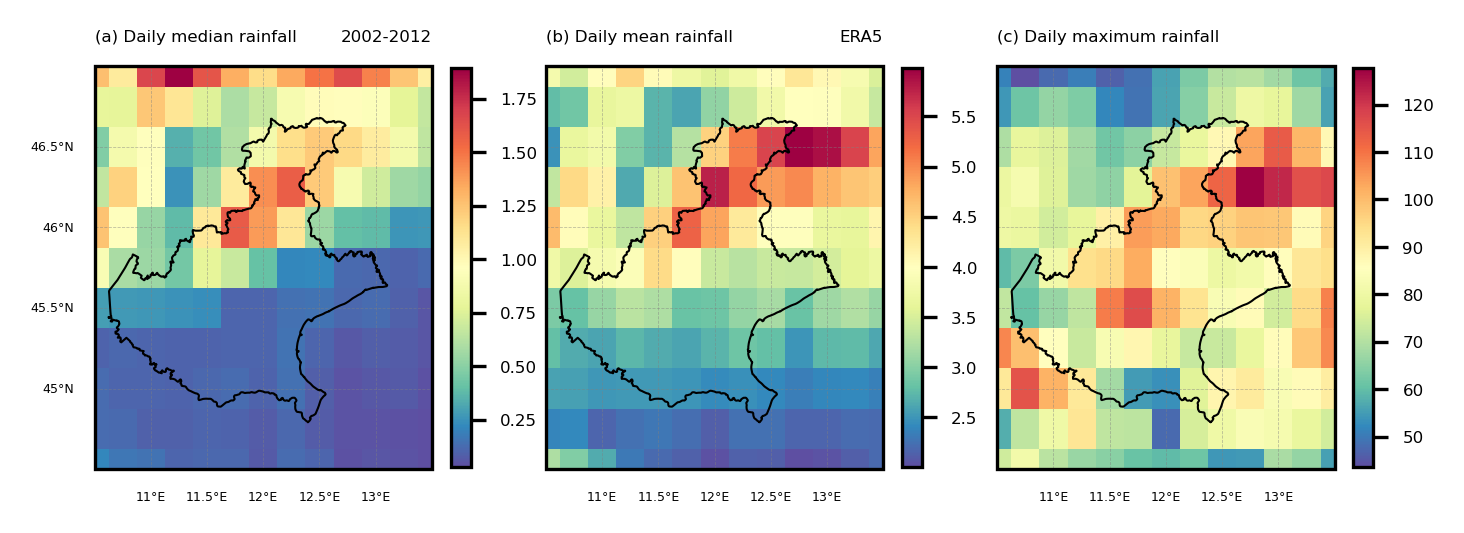

In [7]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(5.5,2),dpi=300)
gs = gridspec.GridSpec(1,3)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)

a1 = ax1.pcolormesh(lon2d, lat2d, PRE_data['PRE'].median(dim='time'),cmap=cmap)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(a) Daily median rainfall', fontsize=4, loc='left')
ax1.set_title(f'{yy_s}-{yy_e}', fontsize=4, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)

a1 = ax1.pcolormesh(lon2d, lat2d, PRE_data['PRE'].mean(dim='time'),cmap=cmap)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(b) Daily mean rainfall', fontsize=4, loc='left')
ax1.set_title(product, fontsize=4, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)

a1 = ax1.pcolormesh(lon2d, lat2d, PRE_data['PRE'].max(dim='time'),cmap=cmap)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(c) Daily maximum rainfall', fontsize=4, loc='left')

## Yearly Weibull Parameters

In [8]:
num_processes = max(1, os.cpu_count() - 2)

def process_point(args):
    i, j, PRE_data, lats, lons = args
    TMP = ART_down.weibull_year_parameters(PRE_data, lats[i], lons[j], 1, 50)
    return i, j, TMP

# Crear lista de argumentos
args = [(i, j, PRE_data, lats, lons) for i in range(len(lats)) for j in range(len(lons))]

# Paralelizar cálculos
with Pool(processes=num_processes) as pool:
    results = pool.map(process_point, args)

# Recolectar resultados
N = np.zeros([years_num, len(lats), len(lons)])
C = np.zeros([years_num, len(lats), len(lons)])
W = np.zeros([years_num, len(lats), len(lons)])

for i, j, TMP in results:
    N[:, i, j] = TMP[:, 0]
    C[:, i, j] = TMP[:, 1]
    W[:, i, j] = TMP[:, 2]

Text(0.0, 1.0, '(c) Mean of Shape parameter')

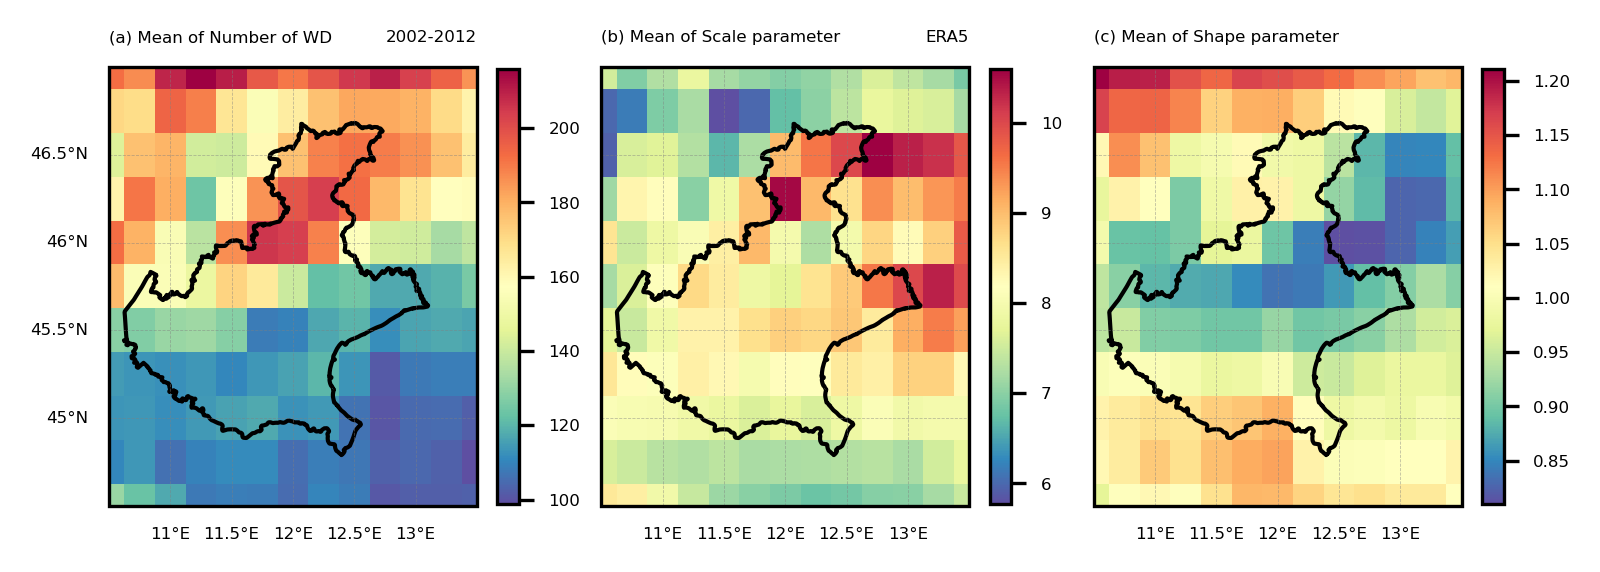

In [9]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(6,3),dpi=300)
gs = gridspec.GridSpec(1,3)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.pcolormesh(lon2d, lat2d, np.mean(N,axis=0), cmap=cmap, transform=proj)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(a) Mean of Number of WD', fontsize=4, loc='left')
ax1.set_title(f'{yy_s}-{yy_e}', fontsize=4, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.pcolormesh(lon2d, lat2d, np.mean(C,axis=0), cmap=cmap, transform=proj)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(b) Mean of Scale parameter', fontsize=4, loc='left')
ax1.set_title(product, fontsize=4, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.pcolormesh(lon2d, lat2d, np.mean(W,axis=0), cmap=cmap, transform=proj)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(c) Mean of Shape parameter', fontsize=4, loc='left')


## Load BETA

In [10]:
BETA_file = f'VENETO_BETA_{product}_{time_reso}_{yy_s}_{yy_e}_npix_{NEIBHR}_v3.nc'
dir_input = os.path.join(dir_base,'1_BETA',BETA_file)
print(f'Reading Beta File : {BETA_file}') 

DATA = xr.open_dataset(dir_input)

BETA = DATA['BETA'].values

del DATA

Reading Beta File : VENETO_BETA_ERA5_3h_2002_2012_npix_5_v3.nc


## Load GAMMA

In [11]:
GAMMA_file = f'VENETO_GAMMA_{product}_{time_reso}_{yy_s}_{yy_e}_npix_{NEIBHR}.nc'
dir_input = os.path.join(dir_base,'2_GAMMA',GAMMA_file)
print(f'Reading Gamma File: {GAMMA_file}') 

DATA = xr.open_dataset(dir_input)

GAMMA = DATA['GAMMA'].values

del DATA

Reading Gamma File: VENETO_GAMMA_ERA5_3h_2002_2012_npix_5.nc


In [12]:
val_ = np.nan
# val_ = -999.9
if product == 'SM2RAIN':
    print('Remove NaN and negatives values in BETA and GAMMA')
    mask = ~np.isnan(PRE_data['PRE'].median(dim='time').values)
    BETA = xr.where(mask, BETA, val_)
    BETA = xr.where((BETA < 0)|(BETA > 5), val_, BETA)
    mask = ~np.isnan(BETA)
    GAMMA = xr.where(mask, GAMMA, val_)
elif product == 'CHIRPS':
    beta_mask = ~np.isnan(np.mean(C,axis=0))
    BETA = np.where(beta_mask, BETA, np.nan)
    BETA[BETA<0] = np.nan
    BETA[BETA>2.1] = np.nan
    GAMMA = np.where(beta_mask, GAMMA, np.nan)
    GAMMA[GAMMA<0] = np.nan

Export figure to: ../figures/BETA_GAMMA/VENETO_ERA5_beta_gamma_3h_npix_5_2002_2012.png


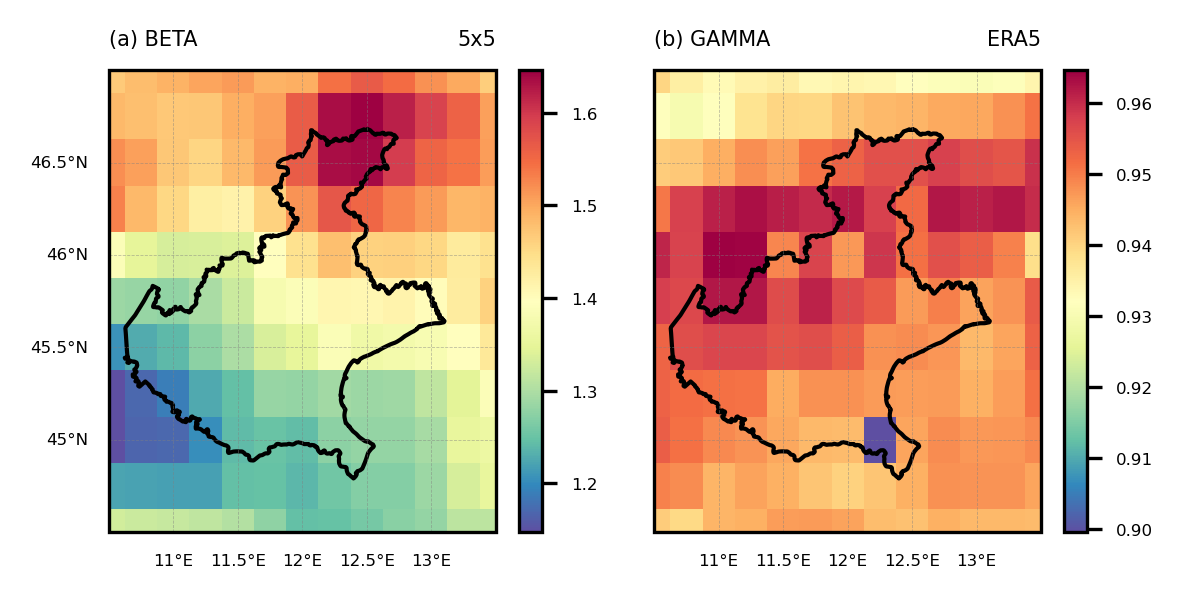

In [13]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(4.3,2),dpi=300)
gs = gridspec.GridSpec(1,2)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.pcolormesh(lon2d, lat2d, BETA, cmap=cmap)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(a) BETA', fontsize=5, loc='left')
ax1.set_title(f'{NEIBHR}x{NEIBHR}', fontsize=5, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.pcolormesh(lon2d, lat2d, GAMMA, cmap=cmap)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(b) GAMMA', fontsize=5, loc='left')
ax1.set_title(f'{product}', fontsize=5, loc='right')

salida = os.path.join('..','figures','BETA_GAMMA',f'VENETO_{product}_beta_gamma_{time_reso}_npix_{NEIBHR}_{yy_s}_{yy_e}.png')
print(f'Export figure to: {salida}')
plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor=None)

## Downscale parameters

In [14]:
print(f'BETA mean: {np.nanmean(BETA)}')
print(f'GAMMA mean: {np.nanmean(GAMMA)}')

BETA mean: 1.386475969625027
GAMMA mean: 0.9479705561169177


In [15]:
Nd, Cd, Wd = ART_down.down_year_parameters(N, C, W, BETA, GAMMA)

In [16]:
# Wd[Wd==np.nanmax(Wd)]=np.nan

Text(0.0, 1.0, '(c) Mean of D-Shape')

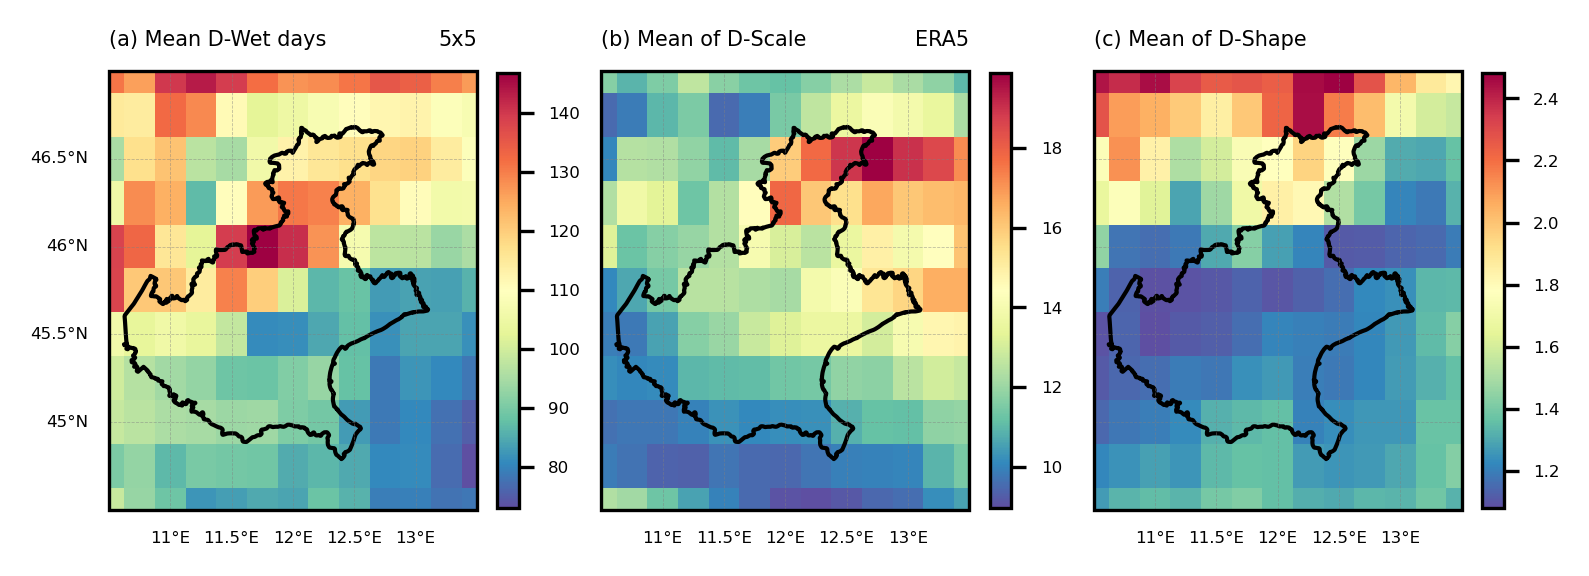

In [17]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(6,3),dpi=300)
gs = gridspec.GridSpec(1,3)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.pcolormesh(lon2d, lat2d, np.mean(Nd,axis=0), cmap=cmap)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(a) Mean D-Wet days', fontsize=5, loc='left')
ax1.set_title(f'{NEIBHR}x{NEIBHR}', fontsize=5, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.pcolormesh(lon2d, lat2d, np.mean(Cd,axis=0), cmap=cmap)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(b) Mean of D-Scale', fontsize=5, loc='left')
ax1.set_title(f'{product}', fontsize=5, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.pcolormesh(lon2d, lat2d, np.mean(Wd,axis=0), cmap=cmap)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(c) Mean of D-Shape', fontsize=5, loc='left')


In [18]:
Tr = [10, 20, 50, 100, 200]
QUANTILE = ART_down.pre_quantiles_array(Nd, Cd, Wd, Tr, lats, lons, 1)

ERROR - fsolve does not work - change x0
ERROR - fsolve does not work - change x0
ERROR - fsolve does not work - change x0
ERROR - fsolve does not work - change x0
ERROR - fsolve does not work - change x0
ERROR - fsolve does not work - change x0
ERROR - fsolve does not work - change x0
ERROR - fsolve does not work - change x0
ERROR - fsolve does not work - change x0
ERROR - fsolve does not work - change x0
ERROR - fsolve does not work - change x0
ERROR - fsolve does not work - change x0
ERROR - fsolve does not work - change x0
ERROR - fsolve does not work - change x0
ERROR - fsolve does not work - change x0
ERROR - fsolve does not work - change x0
ERROR - fsolve does not work - change x0
ERROR - fsolve does not work - change x0
ERROR - fsolve does not work - change x0
ERROR - fsolve does not work - change x0
ERROR - fsolve does not work - change x0
ERROR - fsolve does not work - change x0
ERROR - fsolve does not work - change x0
ERROR - fsolve does not work - change x0
ERROR - fsolve d

/home/arturo/github/downpy/function/ART_downscale.py:332: RuntimeWarning: invalid value encountered in power
  mev0f = np.sum( ( 1-np.exp(-(y/C)**W ))**N) - nyears*pr


In [19]:
if product == 'SM2RAIN':
    QUANTILE = xr.where(QUANTILE < 0, 0, QUANTILE)

Export figure to: ../figures/Tr/VENETO_ERA5_Tr_3h_npix_5_2002_2012.png


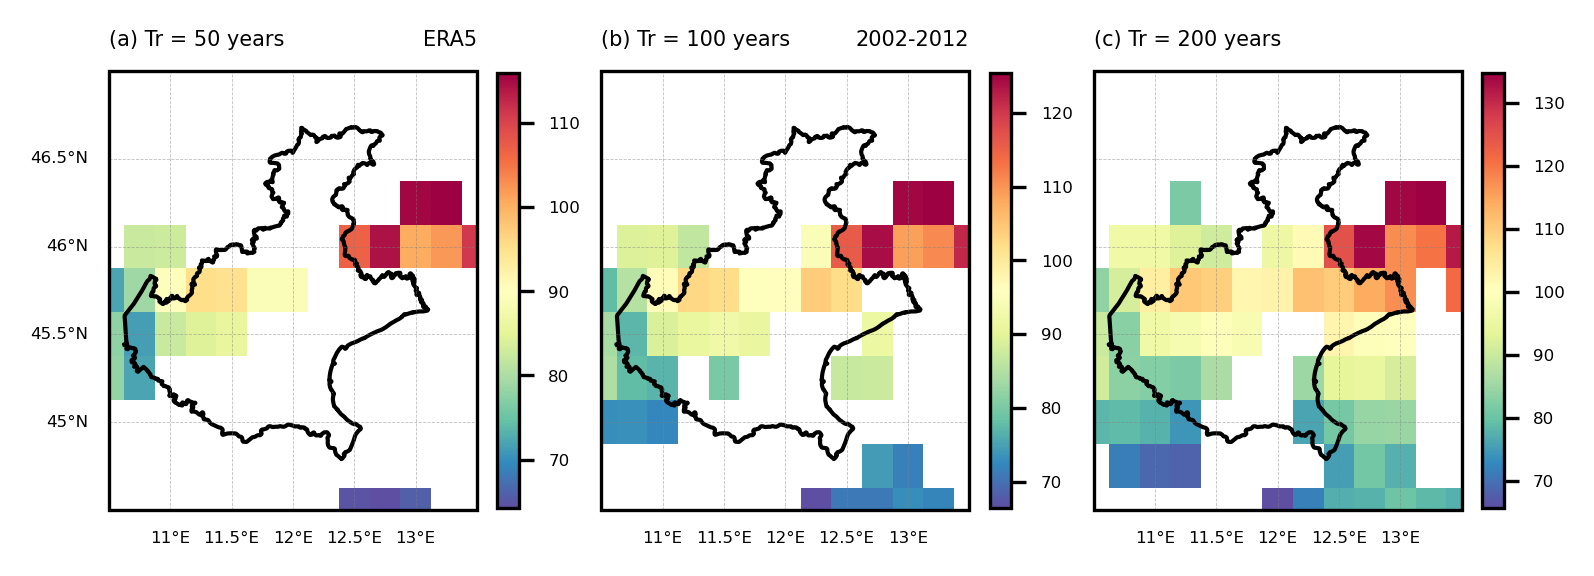

In [20]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(6,3),dpi=300)
gs = gridspec.GridSpec(1,3)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.pcolormesh(lon2d, lat2d, QUANTILE[2,:,:], cmap=cmap, transform=proj)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(a) Tr = {Tr[2]} years', fontsize=5, loc='left')
ax1.set_title(f'{product}', fontsize=5, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.pcolormesh(lon2d, lat2d, QUANTILE[3,:,:], cmap=cmap, transform=proj)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(b) Tr = {Tr[3]} years', fontsize=5, loc='left')
ax1.set_title(f'{yy_s}-{yy_e}', fontsize=5, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.pcolormesh(lon2d, lat2d, QUANTILE[4,:,:], cmap=cmap, transform=proj)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(c) Tr = {Tr[4]} years', fontsize=5, loc='left')

salida = os.path.join('..','figures','Tr',f'VENETO_{product}_Tr_{time_reso}_npix_{NEIBHR}_{yy_s}_{yy_e}.png')
print(f'Export figure to: {salida}')
# plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor=None)

In [21]:
DOWN_xr = xr.Dataset(data_vars={
                    "N": (("year","lat","lon"), N),
                    "C": (("year","lat","lon"), C),
                    "W": (("year","lat","lon"), W),
                    "Nd": (("year","lat","lon"), Nd),
                    "Cd": (("year","lat","lon"), Cd),
                    "Wd": (("year","lat","lon"), Wd),
                    "Quantile": (("Tr","lat","lon"), QUANTILE),
                    },
                    coords={'year':year_vector,'Tr':Tr,'lat': lats, 'lon': lons},
                    attrs=dict(description=f"Yearly Weibull Paramaters Downscale using {product} for Veneto region limited as 10.5E to 13.5E and 44.5N to 47N"))

DOWN_xr.N.attrs["units"] = "day"
DOWN_xr.N.attrs["long_name"] = "Number of wet days"
DOWN_xr.N.attrs["origname"] = "wet days"

DOWN_xr.C.attrs["units"] = "dimensionless"
DOWN_xr.C.attrs["long_name"] = "Weibull scale parameter"
DOWN_xr.C.attrs["origname"] = "scale"

DOWN_xr.W.attrs["units"] = "dimensionless"
DOWN_xr.W.attrs["long_name"] = "Weibull shape parameter"
DOWN_xr.W.attrs["origname"] = "shape"

DOWN_xr.Nd.attrs["units"] = "day"
DOWN_xr.Nd.attrs["long_name"] = "Downscale Number of wet days"
DOWN_xr.Nd.attrs["origname"] = "down wet days"

DOWN_xr.Cd.attrs["units"] = "dimensionless"
DOWN_xr.Cd.attrs["long_name"] = "Downscale Weibull scale parameter"
DOWN_xr.Cd.attrs["origname"] = "down scale"

DOWN_xr.Wd.attrs["units"] = "dimensionless"
DOWN_xr.Wd.attrs["long_name"] = "Downscale Weibull shape parameter"
DOWN_xr.Wd.attrs["origname"] = "down shape"

DOWN_xr.Quantile.attrs["units"] = "mm/day"
DOWN_xr.Quantile.attrs["long_name"] = "Maximum Quantiles"
DOWN_xr.Quantile.attrs["origname"] = "quantiles"

DOWN_xr.lat.attrs["units"] = "degrees_north"
DOWN_xr.lat.attrs["long_name"] = "Latitude"

DOWN_xr.lon.attrs["units"] = "degrees_east"
DOWN_xr.lon.attrs["long_name"] = "Longitude"

In [22]:
DOWN_xr

<xarray.Dataset> Size: 82kB
Dimensions:   (year: 11, lat: 11, lon: 13, Tr: 5)
Coordinates:
  * year      (year) int64 88B 2002 2003 2004 2005 2006 ... 2009 2010 2011 2012
  * Tr        (Tr) int64 40B 10 20 50 100 200
  * lat       (lat) float64 88B 47.0 46.75 46.5 46.25 ... 45.25 45.0 44.75 44.5
  * lon       (lon) float64 104B 10.5 10.75 11.0 11.25 ... 12.75 13.0 13.25 13.5
Data variables:
    N         (year, lat, lon) float64 13kB 193.0 193.0 212.0 ... 103.0 107.0
    C         (year, lat, lon) float64 13kB 8.593 7.752 7.645 ... 7.43 7.366
    W         (year, lat, lon) float64 13kB 1.254 1.179 1.172 ... 1.256 1.125
    Nd        (year, lat, lon) float64 13kB 132.0 130.0 142.0 ... 80.0 78.0 82.0
    Cd        (year, lat, lon) float64 13kB 13.21 12.25 12.19 ... 10.22 10.3
    Wd        (year, lat, lon) float64 13kB 2.612 2.25 2.275 ... 1.854 1.549
    Quantile  (Tr, lat, lon) float64 6kB nan nan nan nan ... 80.33 78.65 77.5
Attributes:
    description:  Yearly Weibull Paramaters Downscale using ERA5 for Veneto r...

In [23]:
DOWN_out = os.path.join(dir_base,'3_DOWN',f'VENETO_DOWN_{product}_{time_reso}_{yy_s}_{yy_e}_npix_{NEIBHR}_v3.nc')
print(f'Export PRE data to {DOWN_out}')
DOWN_xr.to_netcdf(DOWN_out)

Export PRE data to /media/arturo/Arturo/Data/Italy/Satellite/3_DOWN/VENETO_DOWN_ERA5_3h_2002_2012_npix_5_v3.nc


In [24]:
playsound("../sound/HOMER_DOH.mp3")